**1)**
Let's first create some spike trains.

In [1]:
# Import necessary packages
using Random
using Statistics
using PlotlyJS
using DSP  # For convolution

# Set the random seed for reproducibility
Random.seed!(1234)

# Simulation parameters
total_time = 1000.0      # Total simulation time in milliseconds
dt = 1.0                 # Time bin size in milliseconds
t = 0.0:dt:total_time    # Time vector
n_bins = length(t)

# Number of trials
n_trials = 100

# Switch time within a trial
switch_time = total_time / 2  # Switch from Condition 1 to Condition 2 at 500 ms
switch_bin = Int(round(switch_time / dt))  # Corresponding bin index

# Neuron firing rates for the two conditions
rate_before_switch = 20.0   # Average firing rate in Hz before the switch
rate_after_switch = 40.0    # Average firing rate in Hz after the switch

# Create stimulus vector
# 0 for condition before switch, 1 for condition after switch
stimulus = zeros(Int, n_bins)
stimulus[switch_bin+1:end] .= 1

# Calculate the probability of a spike in each bin based on the stimulus condition
prob_spike = zeros(n_bins)
prob_spike[stimulus .== 0] .= rate_before_switch * (dt / 1000.0)  # Convert dt to seconds
prob_spike[stimulus .== 1] .= rate_after_switch * (dt / 1000.0)

# Simulate spike trains for each trial
spike_trains = zeros(Bool, n_trials, n_bins)
for trial in 1:n_trials
    # For each time bin, generate a spike based on the probability
    spike_trains[trial, :] .= rand(n_bins) .< prob_spike
end

**2)**
Visualization: Raster and smoothed PSTH. We are going to use a gaussian kernel here.

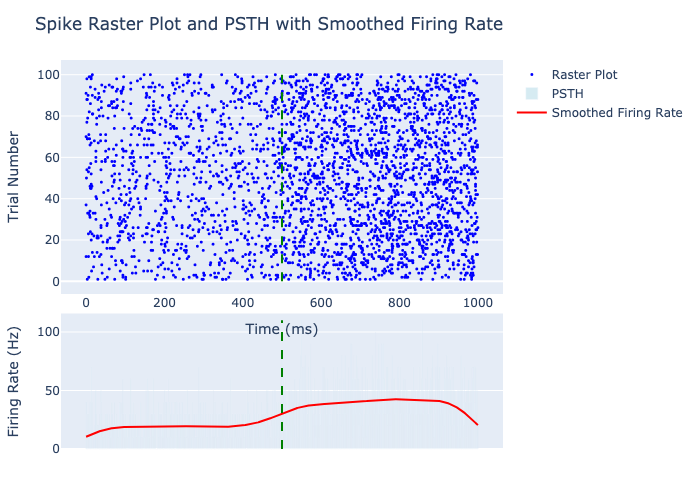

In [2]:
# Prepare data for raster plot
spike_times = Float64[]
trial_numbers = Int[]

for trial in 1:n_trials
    trial_spike_indices = findall(spike_trains[trial, :])
    trial_spike_times = t[trial_spike_indices]
    trial_spike_nums = fill(trial, length(trial_spike_times))
    append!(spike_times, trial_spike_times)
    append!(trial_numbers, trial_spike_nums)
end

# Create raster plot trace
raster_trace = scatter(
    x = spike_times,
    y = trial_numbers,
    mode = "markers",
    marker = attr(
        size = 3,
        color = "blue"
    ),
    name = "Raster Plot"
)

# Compute PSTH (spike count per time bin)
psth = sum(spike_trains, dims=1)  # Sum over trials
psth = vec(psth)  # Convert from 1×n_bins Array to Vector

# Normalize PSTH to get firing rate in Hz
psth_rate = psth ./ n_trials ./ (dt / 1000.0)  # Convert dt to seconds

# Apply Gaussian smoothing to the firing rate
function gaussian_kernel(sigma, dt)
    size = Int(round(6 * sigma / dt))
    if iseven(size)
        size += 1  # Ensure odd size
    end
    x = (-((size - 1) ÷ 2):((size - 1) ÷ 2)) .* dt
    kernel = exp.(-0.5 .* (x ./ sigma).^2) ./ (sigma * sqrt(2 * π))
    kernel = kernel ./ sum(kernel)  # Normalize
    return kernel
end

# Define the standard deviation of the Gaussian kernel in milliseconds
kernel_sigma = 50.0  # 50 ms standard deviation

# Create the Gaussian kernel
kernel = gaussian_kernel(kernel_sigma, dt)

# Smooth the firing rate using convolution
smoothed_rate = conv(psth_rate, kernel)

# Adjust the smoothed_rate to match the original time vector
conv_length = length(smoothed_rate)
desired_length = length(psth_rate)
excess_length = conv_length - desired_length
start_index = excess_length ÷ 2 + 1
end_index = start_index + desired_length - 1
smoothed_rate = smoothed_rate[start_index:end_index]

# Create PSTH plot trace (bar)
psth_trace = bar(
    x = t,
    y = psth_rate,
    name = "PSTH",
    marker = attr(
        color = "lightblue"
    ),
    opacity = 0.5
)

# Create smoothed firing rate trace (line)
smoothed_trace = scatter(
    x = t,
    y = smoothed_rate,
    mode = "lines",
    line = attr(
        color = "red",
        width = 2
    ),
    name = "Smoothed Firing Rate"
)

# Create layout with subplots
layout = Layout(
    title = "Spike Raster Plot and PSTH with Smoothed Firing Rate",
    xaxis = attr(title="Time (ms)"),
    yaxis = attr(title="Trial Number", domain=[0.4, 1.0]),
    yaxis2 = attr(title="Firing Rate (Hz)", domain=[0.0, 0.35]),
    height = 700,
    showlegend = true
)

# Add vertical line indicating switch time
vline = vline = shapes = [
    attr(
        type="line",
        x0=switch_time,
        y0=0,
        x1=switch_time,
        y1=n_trials,
        line=attr(color="green", dash="dash"),
        xref="x1",
        yref="y1"
    ),
    attr(
        type="line",
        x0=switch_time,
        y0=0,
        x1=switch_time,
        y1=maximum(psth_rate),
        line=attr(color="green", dash="dash"),
        xref="x1",
        yref="y2"
    )
]
layout[:shapes] = vline

# Assign traces to subplots
raster_trace[:xaxis] = "x1"
raster_trace[:yaxis] = "y1"

psth_trace[:xaxis] = "x1"
psth_trace[:yaxis] = "y2"

smoothed_trace[:xaxis] = "x1"
smoothed_trace[:yaxis] = "y2"

# Combine traces and layout into a figure
fig = Plot([raster_trace, psth_trace, smoothed_trace], layout)
display(fig)

**3)**
Let's compute the shannon information

In [3]:

# Compute the probability of spiking across all trials
p_spike = mean(spike_trains)
p_no_spike = 1.0 - p_spike

# Compute Shannon entropy (in bits)
function shannon_entropy(p)
    if p == 0.0 || p == 1.0
        return 0.0
    else
        # 这里直接套用了香农公式
        return -p * log2(p) - p_no_spike * log2(p_no_spike)
    end
end

entropy = shannon_entropy(p_spike)

println("Probability of spike per bin (across all trials): $p_spike")
println("Shannon entropy of spike trains: $entropy bits")


Probability of spike per bin (across all trials): 0.0301998001998002
Shannon entropy of spike trains: 0.19539285847074153 bits


**4)**
Now we are calculating mutual information

In [4]:

# Mutual Information Computation
# We will compute the mutual information between the stimulus (S) and the response (R)
# Stimulus S: 0 (before switch), 1 (after switch)
# Response R: Spike (1), No spike (0)
# Total number of observations
total_observations = n_trials * n_bins

# Compute joint probabilities P(S, R)
# Initialize counts
counts = zeros(Int, 2, 2)  # rows: S=0,1; columns: R=0,1

for trial in 1:n_trials
    for bin in 1:n_bins
        s = stimulus[bin]  # 0 or 1
        r = spike_trains[trial, bin] ? 1 : 0  # 0 or 1
        counts[s+1, r+1] += 1  # +1 because Julia arrays are 1-indexed
    end
end

# Convert counts to probabilities
P_SR = counts ./ total_observations  # Joint probabilities P(S, R)
P_S = sum(P_SR, dims=2)  # Marginal probabilities P(S)
P_R = sum(P_SR, dims=1)  # Marginal probabilities P(R)

# Compute mutual information I(S;R)
# as the KL divergence b/w the joint prob. and the product of two probs.
MI = 0.0
for s in 1:2  # S=0,1
    for r in 1:2  # R=0,1
        P_s_r = P_SR[s, r]
        P_s = P_S[s]
        P_r = P_R[r]
        if P_s_r > 0.0
            MI += P_s_r * log2(P_s_r / (P_s * P_r))
        end
    end
end

println("Mutual Information between stimulus and response: $MI bits")


Mutual Information between stimulus and response: 0.002712589955258319 bits


**5**
Let's try to compute the Fisher information of a neuron with Gaussian orientation tuning function

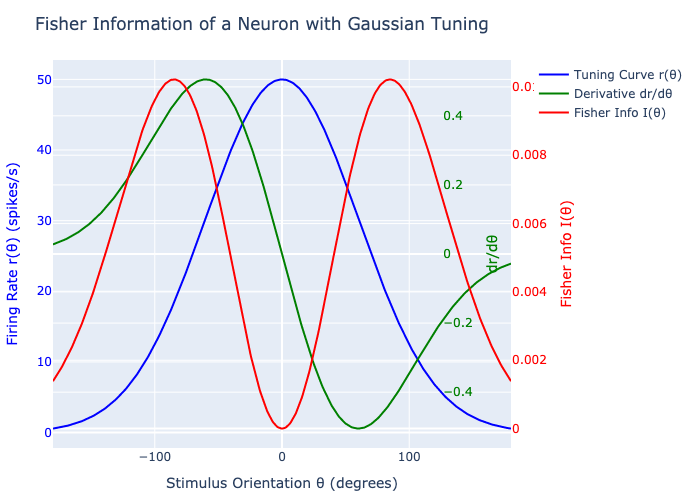

In [8]:
using PlotlyJS

# Parameters for the Gaussian tuning curve
r_max = 50.0  # Maximum firing rate (spikes/s)
θ_pref = 0.0  # Preferred orientation (degrees)
σ = 60.0      # Tuning width (degrees)

# Tuning curve function: r(θ)
function r(θ)
    return r_max * exp( - (θ - θ_pref)^2 / (2 * σ^2) )
end

# Derivative dr/dθ (analytical)
function dr_dθ(θ)
    return r(θ) * (-(θ - θ_pref) / σ^2)
end

# Fisher information I(θ) = (dr/dθ)^2 / r(θ)
function fisher_info(θ)
    r_val = r(θ)
    if r_val == 0.0
        return 0.0
    else
        return (dr_dθ(θ))^2 / r_val
    end
end

# Generate θ values from -180 to 180 degrees
θ_values = range(-180, 180, length=500)

# Compute values for plotting
r_values = r.(θ_values)
dr_values = dr_dθ.(θ_values)
I_values = fisher_info.(θ_values)

# Create Plotly traces
trace_r = scatter(x=θ_values, y=r_values, mode="lines", name="Tuning Curve r(θ)", line=attr(color="blue"))
trace_dr = scatter(x=θ_values, y=dr_values, mode="lines", name="Derivative dr/dθ", line=attr(color="green"), yaxis="y2")
trace_I = scatter(x=θ_values, y=I_values, mode="lines", name="Fisher Info I(θ)", line=attr(color="red"), yaxis="y3")

# Layout with multiple y-axes for different scales
layout = Layout(
    title="Fisher Information of a Neuron with Gaussian Tuning",
    xaxis=attr(title="Stimulus Orientation θ (degrees)"),
    yaxis=attr(title="Firing Rate r(θ) (spikes/s)", side="left", color="blue"),
    yaxis2=attr(title="dr/dθ", overlaying="y", side="right", color="green", position=0.85),
    yaxis3=attr(title="Fisher Info I(θ)", overlaying="y", side="right", color="red"),
    legend=attr(x=1.05, y=1.0),
    width=800,
    height=500
)

# Create and display the plot
p = plot([trace_r, trace_dr, trace_I], layout)
display(p)  # Opens in browser or Jupyter

